In [75]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append(os.path.abspath(''))
import numpy as np
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from functions import plotgenerator as pg
import utils, model, egm, simulations, estimation 

# Solution to the model

In [3]:
# Setup
par_init_sol = model.gp_model()

### plotting Income shifter

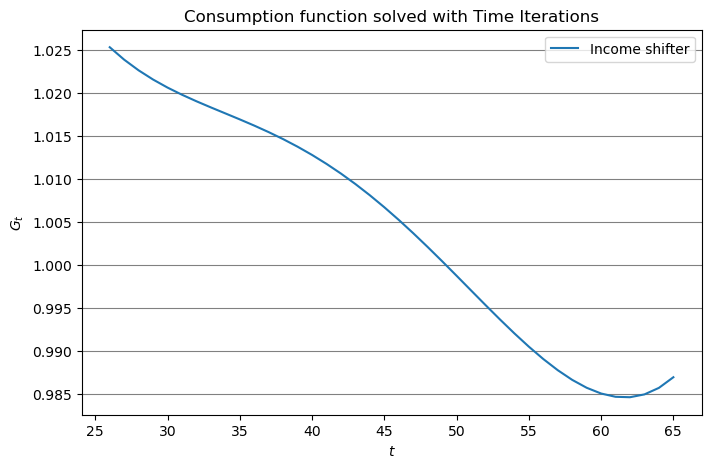

In [4]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(range(par_init_sol.par.t0,par_init_sol.par.Tr+1),par_init_sol.par.G, label=f"Income shifter", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

### solving the model

In [5]:
# Solve the model
solObj = egm.solver(par_init_sol.par)
solObj.solve(do_print=False)
sol = solObj.sol


### plotting the results

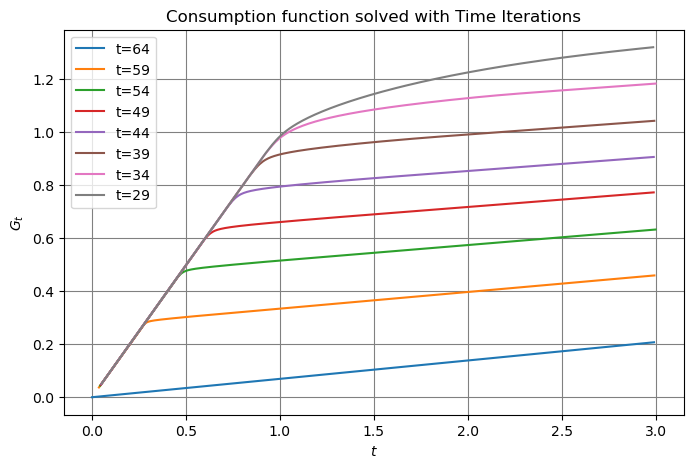

In [6]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
for t in range(par_init_sol.par.Tr_N-1,par_init_sol.par.t0_N,-5):
    criteria = np.where(sol.m[:,t] <= 3, True, False)
    fig.add_plot(sol.m[criteria,t],sol.c[criteria,t], label=f"t={25+t}", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='both')
fig.add_legend()
fig.show()

### simulate how results look like

In [7]:
sim = simulations.Simulator(par_init_sol.par, sol).sim

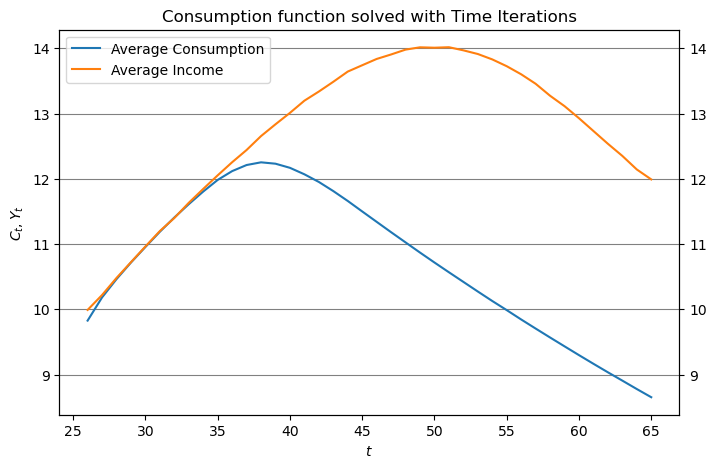

In [8]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t, Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

# Estimation based on random data

### Data generation

In [9]:
# Setup params
par_dgp = model.gp_model().par
par_dgp.beta = 0.95
par_dgp.rho = 0.45
sol_dgp = egm.solver(par_dgp)
sol_dgp.solve(do_print=False)

dgp_par = [par_dgp.beta, par_dgp.rho]
# 
# sim_dgp = simulations.sim_setup(par_dgp)
# simulations.draw_random(par_dgp, sim_dgp)
# sim_dgp = simulations.simulate(sim_dgp, par_dgp, sol_dgp.sol)
sim_dgp = simulations.Simulator(par_dgp, sol_dgp.sol).sim

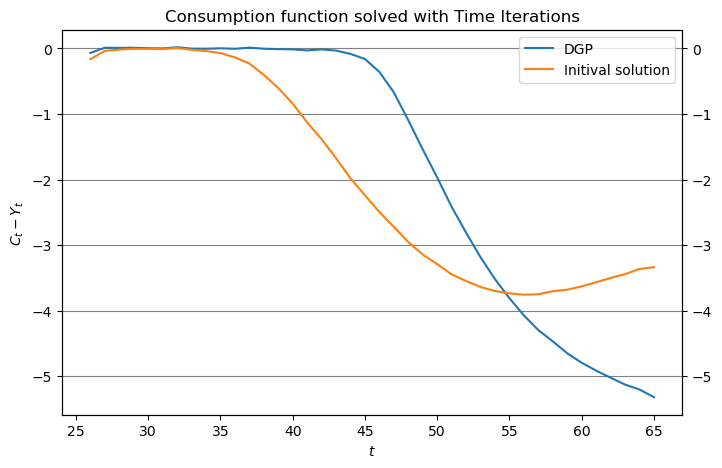

In [10]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
y1 = sim_dgp.C_avg - sim_dgp.Y_avg
y2 = sim.C_avg - sim.Y_avg
fig.add_plot(x,y1, label=f"DGP", linestyle='-',axis='y1')
fig.add_plot(x,y2, label=f"Initival solution", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t - Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [11]:
weight_mat_inv = np.eye(sim_dgp.C_avg.size)   # The identity matrix and I^-1=I
est = estimation.SMD(model=par_dgp,solver=egm.solver, simulator=simulations.Simulator, mom_data=sim_dgp.C_avg)

### grid search

In [12]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [13]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [14]:
print(f'estimated values using grid method {est.est} and true parameters {dgp_par}')

estimated values using grid method [0.95000092 0.44997579] and true parameters [0.95, 0.45]


In [15]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[ 1.61372834e+18 -4.66617513e+19]
 [-4.66617513e+19  1.34924757e+21]]


### plot the objective function for different values

In [16]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()

# Estimation using data from BLS

In [85]:
cat = ['Under 25 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65 years and older']
data = [46359, 67883, 86049, 91074, 78079, 57818]
for i in range(6):
    print(f"{cat[i]}: {data[i]:,.1f}")

Under 25 years: 46,359.0
25-34 years: 67,883.0
35-44 years: 86,049.0
45-54 years: 91,074.0
55-64 years: 78,079.0
65 years and older: 57,818.0


[67883.       70040.508375 72145.692    74189.763625 76163.936
 78059.421875 79867.434    81579.185125 83185.888    84678.755375
 86049.       87287.834625 88386.472    89336.124875 90128.006
 90753.328125 91203.304    91469.146375 91542.068    91413.281625
 91074.       90519.344125 89760.068    88810.833875 87686.304
 86401.140625 84970.006    83407.562375 81728.472    79947.397125
 78079.       76137.942875 74138.888    72096.497625 70025.434
 67940.359375 65855.936    63786.826125 61747.692    59753.195875]


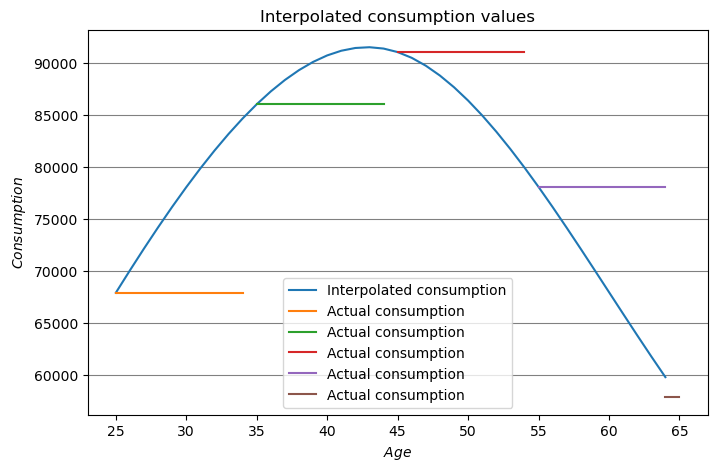

In [109]:
from scipy.interpolate import interp1d
age_groups = [25, 35, 45, 55, 65]
consumptions = data[1:]
# Create the interpolation function
interp_function = interp1d(age_groups, consumptions, kind='cubic', fill_value="extrapolate")

# Generate the ages for which we want to interpolate
ages = np.arange(25, 65)
# Interpolate the consumption values for these ages
interpolated_consumptions = interp_function(ages)
print(interpolated_consumptions)

# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(ages, interpolated_consumptions, label=f"Interpolated consumption", linestyle='-')
fig.add_plot(np.arange(25,35), np.repeat(data[1],np.arange(25,35).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(35,45), np.repeat(data[2],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(45,55), np.repeat(data[3],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(55,65), np.repeat(data[4],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(64,66), np.repeat(data[5],np.arange(44,46).shape[0]), label=f"Actual consumption", linestyle='-')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Interpolated consumption values')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [110]:
# Setup
par_real = model.gp_model().par
# solve model
solObj = egm.solver(par_real)
solObj.solve()
sol_real = solObj.sol

real_par = [par_real.beta, par_real.rho]
# 
sim_real = simulations.Simulator(par_real, sol_real).sim

In [111]:
est.sim.C_avg
for i in range(0,len(est.sim.C_avg),10):
    print(f'{i+25}-{i+25+10}', est.sim.C_avg[i:i+10].mean())

25-35 11.04853877062116
35-45 13.02513670823114
45-55 11.781358527748585
55-65 8.025188248513619


In [112]:
real_data = np.array([67883, 86049, 91074, 78079])
real_data = np.log(interpolated_consumptions)
print(real_data,'\n',len(real_data))

[11.12554091 11.15682904 11.18644285 11.21438146 11.24064335 11.26522563
 11.28812346 11.30932942 11.328833   11.34662003 11.36267218 11.37696638
 11.38947421 11.40016122 11.40898623 11.41590043 11.4208464  11.423757
 11.42455391 11.42314606 11.41942764 11.41331885 11.40489548 11.39426392
 11.381521   11.36675616 11.3500536  11.33149426 11.31115771 11.28912416
 11.26547641 11.24030201 11.21369548 11.18576075 11.1566138  11.12638553
 11.09522485 11.06330196 11.03081188 10.99797796] 
 40


In [113]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = estimation.SMD(model=par_real,solver=egm.solver, simulator=simulations.Simulator, mom_data=real_data)
est_real.age_groups = False

In [118]:
est_real.beta_grid = np.arange(0.85,0.95,0.01)
est_real.rho_grid = np.arange(0.15,0.25,0.01)
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv,grid=True)

In [116]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=[(0.6,1.05),(0.05,0.99)],W=weight_mat_inv,grid=False)

In [117]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')

True
estimated values [0.9668168  0.21552685] with objective function value 17.454804293015307


In [119]:
if hasattr(est_real,'grid'):
  from plotly.subplots import make_subplots

  fig = make_subplots(
      rows=1, 
      cols=2,
      start_cell="top-left", 
      specs=[
          [{"type": "surface"}, {"type": "scattergl"}], 
      ]
  )
  fig.update_layout(paper_bgcolor="rgba(0,0,0,0)",plot_bgcolor="grey",font=dict(family="Arial",size=12,color="white"))
  # Sample data
  x, y = np.meshgrid(est_real.beta_grid, est_real.rho_grid)
  z = est_real.grid

  # Create the surface plot
  # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.add_trace(go.Surface(z=z, x=x, y=y, #coloraxis=dict(coloraxis=1),
                           ),row=1,col=1)

  # Update axes titles for the mesh plot
  fig.update_scenes(
      xaxis_title='Beta',
      yaxis_title='Rho',
      zaxis_title='Objective function',
      row=1, col=1
  )
  fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7),
                     row=1, col=1)

  fig.update_layout(title='Objective function', autosize=False,width=1000, height=500,margin=dict(l=65, r=50, b=65, t=90))
  # set the background color
  y = est_real.grid[np.where(est_real.beta_grid == est_real.est[0])[0],:][0]
  x = est_real.rho_grid

  # fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='lines', ),row=1,col=2)
  # Update axes titles for each subplot
  fig.update_xaxes(title_text=f'rho', row=1, col=2)
  fig.update_yaxes(title_text='Objective function', 
                   row=1, col=2)

  fig.show()
else:
  print('No grid found')

# Extension
Imagine two types of households with different timepreference, $\beta$

#### Type I

In [77]:
# Setup params
par_type1 = model.gp_model().par
par_type1.beta = 0.99
sol_type1 = egm.solver(par_type1)
sol_type1.solve()
sol_type1 = sol_type1.sol

type1_par = [par_type1.beta, par_type1.rho]
# 
sim_type1 = simulations.Simulator(par_type1, sol_type1).sim

#### Type II

In [78]:
# Setup params
par_type2 = model.gp_model().par
par_type2.beta = 0.90
sol_type2 = egm.solver(par_type2)
sol_type2.solve()
sol_type2 = sol_type2.sol

type2_par = [par_type2.beta, par_type2.rho]

sim_type2 = simulations.Simulator(par_type2, sol_type2).sim

#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

In [79]:
lambda1 = 0.4
lambda2 = 1 - lambda1
agg_model = model.gp_model().par
agg_cons = lambda1*sim_type1.C_avg + lambda2 * sim_type2.C_avg

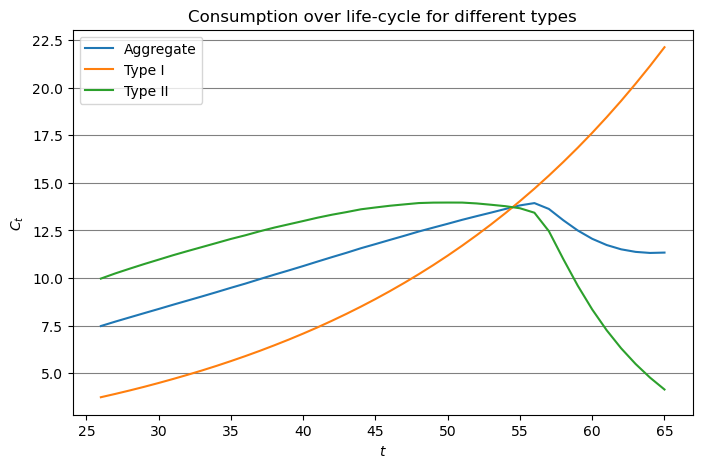

In [80]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,agg_cons, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_type1.C_avg, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_type2.C_avg, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [81]:
weight_mat_inv = np.eye(agg_cons.shape[0])   # The identity matrix and I^-1=I
est_ext = estimation.SMD(model=agg_model,solver=egm.solver, simulator=simulations.Simulator, mom_data=agg_cons)

In [82]:
est_ext.beta_grid = np.arange(0.9,0.99,0.01)
est_ext.rho_grid = np.arange(0.4,0.5,0.01)
est_ext.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

In [83]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est_ext.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()
print(f'estimated values using grid method {est_ext.est} ')

estimated values using grid method [0.9700000000000001, 0.4] 


In [84]:
est_ext.estimate(theta0=[0.97,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {est_ext.est}')
else:
    print(f'optimization failed')